# 04. Scenario analysis, Denmark-wide
## Project: Bicycle node network loop analysis

This notebook analyses loops created in notebook 02 with different scenarios for the whole country of Denmark.    
Please select `denmark` as the `study_area` in the `config.yml`.  

Explore three scenarios:  
1. Family with small children: 5-20km, max slope 4%
1. Teenage/adult leisure cyclist: 10-40km, max slope 6%
1. Family with e-bikes: 10-40km, max slope 100%

Contact: Michael Szell (michael.szell@gmail.com)

Created: 2024-10-25  
Last modified: 2025-08-25

## Parameters

In [1]:
%run -i setup_parameters.py
load_data = True  # Set to False if data are huge and have already been loaded
debug = True  # Set to True for extra plots and verbosity

In [2]:
try:  # See if allloops_dict exists. If not, initialize. This allows running multiple scenarios.
    allloops_dict
except NameError:
    allloops_dict = {}
allloops_dict[SCENARIOID] = {}

In [3]:
print("Running scenario " + str(SCENARIOID) + " in " + STUDY_AREA)
for k, v in SCENARIO[SCENARIOID].items():
    print(k + ": " + str(v))

Running scenario 2 in bornholm
name: Family with e-bikes
name_short: Family e-bikes
maxslope_limit: 100
looplength_min: 10000
looplength_max: 40000


## Functions

In [4]:
%run -i functions.py

## Load data

This can take several minutes.

In [5]:
if load_data:
    if LOOP_LENGTH_BOUND:
        llb_string = "_maxlength" + str(LOOP_LENGTH_BOUND)
    else:
        llb_string = ""

    with open(
        PATH["data_out"]
        + "loopcensus_"
        + str(LOOP_NUMNODE_BOUND)
        + llb_string
        + ".pkl",
        "rb",
    ) as f:
        allloops = pickle.load(f)
        alllooplengths = pickle.load(f)
        allloopnumnodes = pickle.load(f)
        allloopmaxslopes = pickle.load(f)
        Gnx = pickle.load(f)
        LOOP_NUMNODE_BOUND = pickle.load(f)
        nodes_id = pickle.load(f)
        nodes_coords = pickle.load(f)
        #numloops = pickle.load(f)
        faceloops = pickle.load(f)

In [6]:
# Create gdf and igraph versions
nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)
G = ig.Graph.from_networkx(Gnx)
G.summary()

/var/folders/q4/95x26cls17s1z694v56lw3hh0000gn/T/ipykernel_58703/3993341458.py:2: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)


'IGRAPH UNW- 59 89 -- \n+ attr: _nx_name (v), name (v), nodeID (v), x (v), y (v), edge_id (e), geometry (e), has_attraction (e), has_facility (e), has_service (e), has_water (e), max_slope (e), node_end (e), node_start (e), poi_diversity (e), weight (e)'

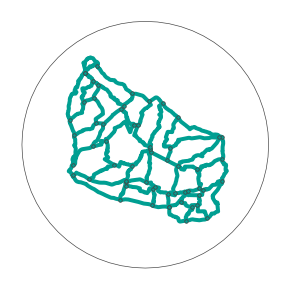

In [7]:
# Plot network
if debug:
    plot_dk_gdf(
        nodes,
        edges,
        scale=0.4,
        vertex_size=get_vertex_size_constant(G.vcount()),
        link_width=get_edgewidth_constant(G.ecount()),
    )

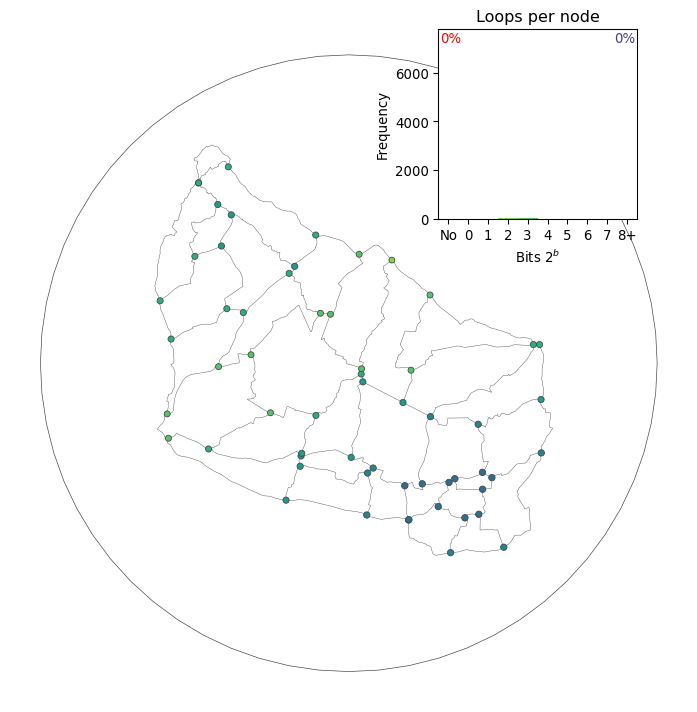

In [8]:
# Plot all loops
vertex_sizes, vertex_colors = get_vertex_plotinfo(allloops)
fig, ax = plot_dk_gdf(
    nodes,
    edges,
    scale=1,
    vertex_size=vertex_sizes,
    vertex_color=vertex_colors,
    link_width=0.3,
    link_color="#444444",
)
plot_dk_inset(fig, allloops, 8, 7800)
fig.savefig(PATH["plot"] + "network_numloops_all" + "." + PLOTPARAM["format"])

## Analyse

### Restrict to scenario lengths

In [9]:
allloops_dict[SCENARIOID][0] = restrict_scenario(allloops, allloops, level=0)

Restrict to scenario lengths:   0%|          | 0/59 [00:00<?, ?it/s]

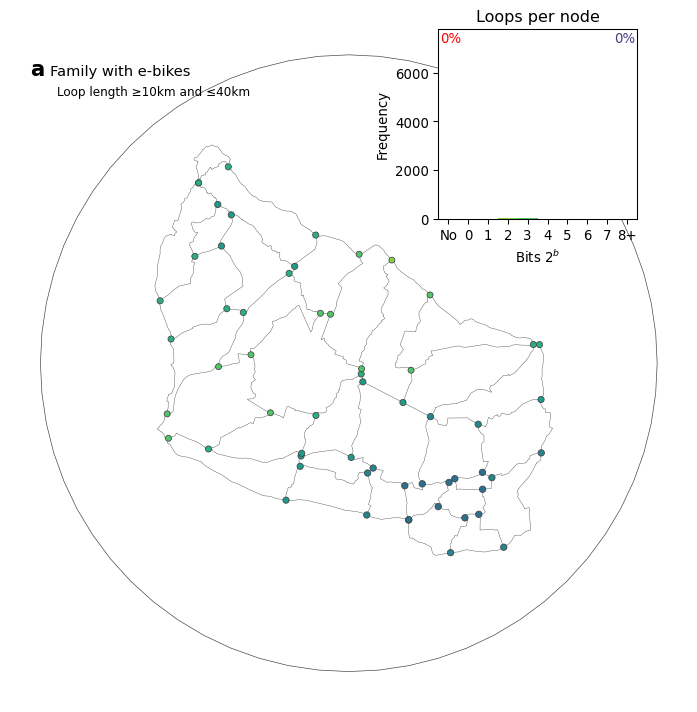

In [10]:
# Plot all bounded loops
vertex_sizes, vertex_colors = get_vertex_plotinfo(allloops_dict[SCENARIOID][0])
fig, ax = plot_dk_gdf(
    nodes,
    edges,
    scale=1,
    vertex_size=vertex_sizes,
    vertex_color=vertex_colors,
    link_width=0.3,
    link_color=PLOTPARAM["color"]["neutral"],
    subplotlabel="a",
    subplotlabelx=0.03,
    subplotlabely=0.925,
)
plot_dk_scenariotext(ax, filterdepth=1)
plot_dk_inset(fig, allloops_dict[SCENARIOID][0], 8, 7800)

fig.savefig(
    PATH["plot"]
    + "network_numloops_"
    + str(SCENARIO[SCENARIOID]["looplength_min"])
    + "to"
    + str(SCENARIO[SCENARIOID]["looplength_max"])
    + "."
    + PLOTPARAM["format"]
)

### Restrict to scenario gradients

In [11]:
allloops_dict[SCENARIOID][1] = restrict_scenario(
    allloops, allloops_dict[SCENARIOID][0], level=1
)

Restrict to scenario gradients:   0%|          | 0/59 [00:00<?, ?it/s]

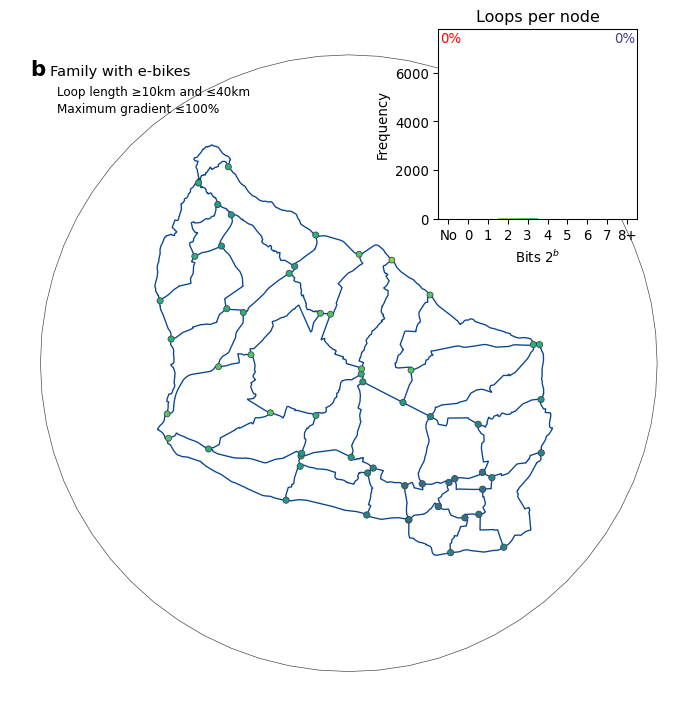

In [12]:
# Plot all bounded sloped loops
vertex_sizes, vertex_colors = get_vertex_plotinfo(allloops_dict[SCENARIOID][1])
link_widths, link_colors = get_link_plotinfo(
    edges,
    var_bad="max_slope",
    var_good="poi_diversity",
    threshold_bad=SCENARIO[SCENARIOID]["maxslope_limit"],
    threshold_good=0,
)
fig, ax = plot_dk_gdf(
    nodes,
    edges,
    scale=1,
    vertex_size=vertex_sizes,
    vertex_color=vertex_colors,
    link_width=link_widths,
    link_color=link_colors,
    subplotlabel="b",
    subplotlabelx=0.03,
    subplotlabely=0.925,
)
plot_dk_scenariotext(ax, filterdepth=2)
plot_dk_inset(fig, allloops_dict[SCENARIOID][1], 8, 7800)

fig.savefig(
    PATH["plot"]
    + "network_numloops_"
    + str(SCENARIO[SCENARIOID]["looplength_min"])
    + "to"
    + str(SCENARIO[SCENARIOID]["looplength_max"])
    + "_maxslope"
    + str(SCENARIO[SCENARIOID]["maxslope_limit"])
    + "."
    + PLOTPARAM["format"]
)

### Restrict to water limits

In [13]:
allloops_dict[SCENARIOID][2] = restrict_scenario(
    allloops, allloops_dict[SCENARIOID][1], level=2
)

Restrict to water limits:   0%|          | 0/59 [00:00<?, ?it/s]

/Users/jqz304/Documents/bikenwloops/code/functions.py:96: RuntimeWarning: divide by zero encountered in log2
  math.ceil(np.log2(len(loopinfo[k]["loops"]))), 0, bit_threshold + 1


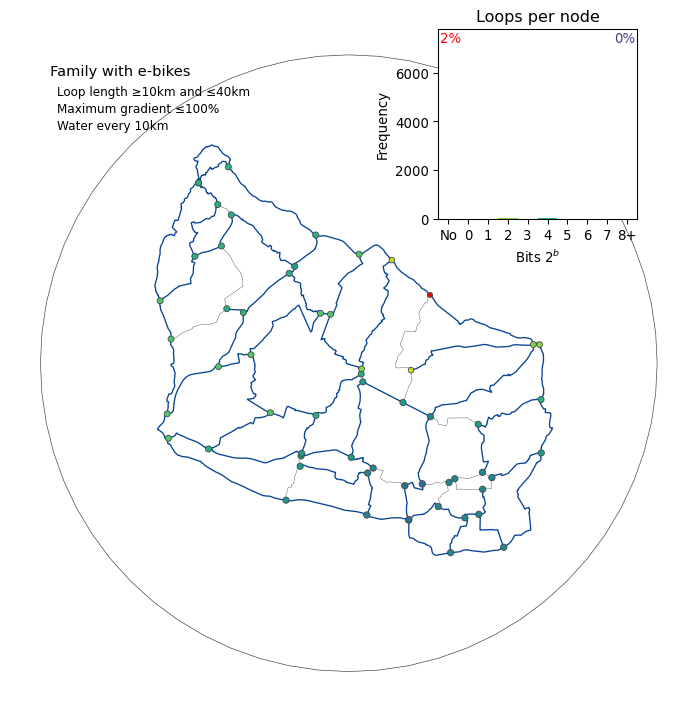

In [14]:
# Plot all bounded sloped loops
vertex_sizes, vertex_colors = get_vertex_plotinfo(allloops_dict[SCENARIOID][2])
link_widths, link_colors = get_link_plotinfo(
    edges,
    var_bad="max_slope",
    var_good="poi_diversity",
    threshold_bad=SCENARIO[SCENARIOID]["maxslope_limit"],
    threshold_good=1,
)
if SCENARIO[SCENARIOID]["name"] == "Family with e-bikes":
    spl = ""
else:
    spl = "a"
fig, ax = plot_dk_gdf(
    nodes,
    edges,
    scale=1,
    vertex_size=vertex_sizes,
    vertex_color=vertex_colors,
    link_width=link_widths,
    link_color=link_colors,
    subplotlabel=spl,
    subplotlabelx=0.03,
    subplotlabely=0.925,
)
plot_dk_scenariotext(ax, filterdepth=3)
plot_dk_inset(fig, allloops_dict[SCENARIOID][2], 8, 7800)


fig.savefig(
    PATH["plot"]
    + "network_numloops_"
    + str(SCENARIO[SCENARIOID]["looplength_min"])
    + "to"
    + str(SCENARIO[SCENARIOID]["looplength_max"])
    + "_maxslope"
    + str(SCENARIO[SCENARIOID]["maxslope_limit"])
    + "_waterlength_max"
    + str(WATERLENGTH_MAX)
    + "."
    + PLOTPARAM["format"]
)

### Restrict with POI diversity

In [15]:
allloops_dict[SCENARIOID][3] = restrict_scenario(
    allloops, allloops_dict[SCENARIOID][2], level=3
)

Restrict with POI diversity:   0%|          | 0/59 [00:00<?, ?it/s]

/Users/jqz304/Documents/bikenwloops/code/functions.py:96: RuntimeWarning: divide by zero encountered in log2
  math.ceil(np.log2(len(loopinfo[k]["loops"]))), 0, bit_threshold + 1


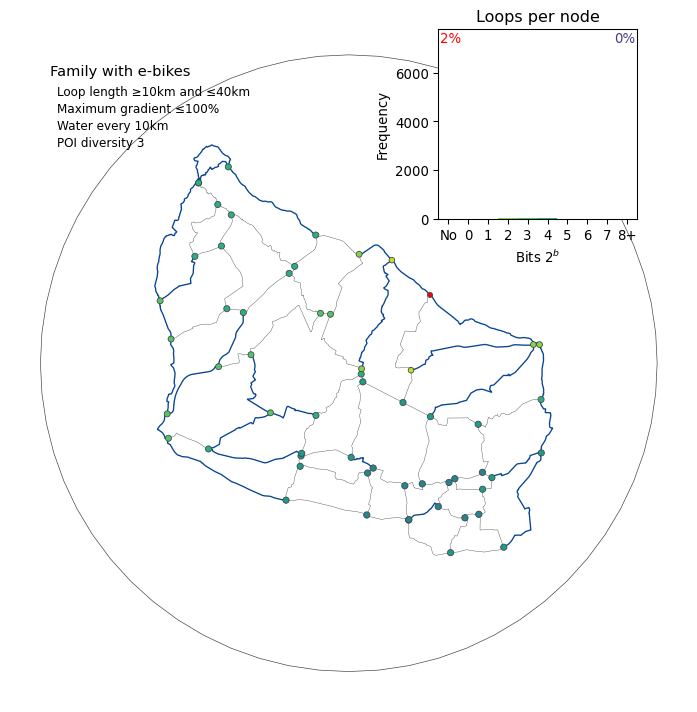

In [16]:
# Plot all bounded sloped loops
vertex_sizes, vertex_colors = get_vertex_plotinfo(allloops_dict[SCENARIOID][3])
link_widths, link_colors = get_link_plotinfo(
    edges,
    var_bad="max_slope",
    var_good="poi_diversity",
    threshold_bad=SCENARIO[SCENARIOID]["maxslope_limit"],
    threshold_good=3,
)
if SCENARIO[SCENARIOID]["name"] == "Family with e-bikes":
    spl = ""
else:
    spl = "b"
fig, ax = plot_dk_gdf(
    nodes,
    edges,
    scale=1,
    vertex_size=vertex_sizes,
    vertex_color=vertex_colors,
    link_width=link_widths,
    link_color=link_colors,
    subplotlabel=spl,
    subplotlabelx=0.03,
    subplotlabely=0.925,
)
plot_dk_scenariotext(ax, filterdepth=4)
plot_dk_inset(fig, allloops_dict[SCENARIOID][3], 8, 7800)

fig.savefig(
    PATH["plot"]
    + "network_numloops_"
    + str(SCENARIO[SCENARIOID]["looplength_min"])
    + "to"
    + str(SCENARIO[SCENARIOID]["looplength_max"])
    + "_maxslope"
    + str(SCENARIO[SCENARIOID]["maxslope_limit"])
    + "_waterlength_max"
    + str(WATERLENGTH_MAX)
    + "_poidiversity3"
    + "."
    + PLOTPARAM["format"]
)